In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [158]:
class RecSim():
    '''
    This is RecSim, a simulation class in Python for simulating the microphysics in liquid xenon to describe luminescence 
    from the recombination process.
    '''
    # Holds a list of dicts giving time-dependent information
    d = []
    # Holds a dict with all the grids (for electrons, ions, etc)
    grids = {}
    
    nbins = 0
    coord_names = np.array(['x', 'y', 'z'])
    coord_stepsizes = []
    coord_nbins = []
    coord_values = None
    t = 0.
    dt = 0.
    # Default parameters
    config = dict(
        # Physics
        e_diff_const = 0.1, alpha=0.1, tau=22, 
        # Drift
        drift = False, v_d = 1.404, 
        # Simulation settings
        max_outflow_fraction = 0.2, max_n_errors = 5, 
    )
    # Technical paramaters
    n_errors = 0
    
    def __init__(self, coord_nbins, coord_stepsizes, dt, **config):
        '''
        Initialize simulation.
        '''
        
        # Set the bin steps and sizes
        self.coord_nbins = np.array(coord_nbins)
        self.coord_stepsizes = np.array(coord_stepsizes)
        self.dt = dt
        
        # Derived quantities
        self.bin_volume = np.product(self.coord_stepsizes)
        self.bin_surface = [self.bin_volume / stepsize for stepsize in self.coord_stepsizes]
        self.coord_range = self.coord_stepsizes * self.coord_nbins
        
        # Take additional settings. If specified in init, overwrite the default
        for key in self.config.keys():
            if key in config.keys():
                self.config[key] = config[key]
                
        # Remove previous data
        self.d = []
        self.grids = {}
        self.t = 0.
        return

    
        
    def initialize_grid(self, name):
        '''
        Initialize a grid for the parameter given by `name`
        '''
        if name in self.grids.keys():
            print('Grid for %s already exists, skipping...' % name)
            return
        self.grids[name] = np.zeros(shape=self.coord_nbins, dtype=float)
        return
        
    def set_density_sphere(self, name, radius, constvalue = 1.,  center=None):
        '''
        Set the density of the parameter with name `name` to a constant density within a sphere.
        Radius is given in units of length (not number of bins).
        Center is given in bin coordinates and defaults to center location.
        '''
        if center is None:
            # default position is central position
            center = [round((coord_nbin - 1) / 2) for coord_nbin in self.coord_nbins]
        # Recalculate the radius to number of bin steps (different per dimension possible if different step sizes)
        radius_bins = [radius / coord_step for coord_step in self.coord_stepsizes]
        # Calculate the distance from center in units of fraction of the full radius
        r_from_center = np.zeros(dtype=float, shape=self.coord_nbins)
        for i in range(self.coord_nbins[0]):
            for j in range(self.coord_nbins[1]):
                for k in range(self.coord_nbins[2]):
                    r_from_center[i, j, k] = (((i - center[0]) / radius_bins[0])**2 + 
                                               ((j - center[1]) / radius_bins[1])**2 +
                                               ((k - center[2]) / radius_bins[2])**2)
        r_from_center = np.sqrt(r_from_center)
        self.grids[name][r_from_center <= 1] = constvalue
        return
    
    def set_density_cylinder(self, name, radius, length, constvalue, center=None):
        '''
        Set the density to a cylinder in x.
        Radius is given in units of length (not number of bins).
        Center is given in bin coordinates and defaults to center location.
        '''
        if center is None:
            # default position is central position
            center = [round((coord_nbin - 1) / 2) for coord_nbin in self.coord_nbins]
        # Recalculate the radius to number of bin steps (different per dimension possible if different step sizes)
        radius_bins = [radius / coord_step for coord_step in self.coord_stepsizes[1:]]
        length_bins = length / self.coord_stepsizes[0]
        # Calculate the distance from center in units of fraction of the full radius, only for y and z
        r_from_center = np.zeros(dtype=float, shape=self.coord_nbins)
        for j in range(self.coord_nbins[1]):
            for k in range(self.coord_nbins[2]):
                r_from_center[:, j, k] = (((j - center[1]) / radius_bins[0])**2 +
                                          ((k - center[2]) / radius_bins[1])**2)
        r_from_center = np.sqrt(r_from_center)
        z_from_center = np.zeros(dtype=float, shape=self.coord_nbins)
        for i in range(self.coord_nbins[0]):
            z_from_center[i, :, :] = np.abs(i - center[0]) / length_bins

        self.grids[name][(r_from_center <= 1) & (z_from_center <= 0.5)] = constvalue
        return
    
    def plot_density_2d(self, name, project_axis = 1, **kwargs):      
        '''
        Make a 2d density plot of the density.
        '''
        plotgrid = np.sum(self.grids[name], axis=project_axis)
        x, y = [name for i, name in enumerate(self.coord_names) if i != project_axis]
        x_index, y_index =  [i for i, name in enumerate(self.coord_names) if i != project_axis]
        aspect = self.coord_stepsizes[y_index] / self.coord_stepsizes[x_index]
        plt.imshow(plotgrid.T, aspect = aspect, **kwargs)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(name)
        return 
    
    def plot_density(self, name, axis = 0, **kwargs):
        
        axes_to_project = [i for i in range(3) if i!= axis]
        plotgrid = np.sum(self.grids[name], axis=tuple(axes_to_project))
        # plotgrid = np.sum(plotgrid, axis=axes_to_project[1])
        plt.plot(range(self.coord_nbins[axis]) * self.coord_stepsizes[axis],
                 plotgrid, label = 't = %.2f' % self.t, **kwargs)
        plt.xlabel('%s (um)' % self.coord_names[axis])
        return
    
    def plot_t(self, name, **kwargs):
        d = self.data()
        plt.plot(d['t'], d[name], **kwargs)
        plt.xlabel('t (ns)')
        return
    
    def diffuse(self, name, diffconst):
        '''
        Apply diffusion to the grid with parameter `name`.
        The diffusion constant must be given in units of (distance)^2/(time) (i.e. um^2/ns?)
        '''
        ret = {}       
        # Get the density values for this grid
        grid = self.grids[name]
        ret[name + '_sum'] = np.sum(grid)
        
        # Diffusion is applied by shifting all bins to +1 and -1 in all coordinates.
        # After that, we calculate:
        # J = - D delta_n/dx     delta_n = n(x+dx) - n(x)
        # dN = J dS dt
        # dn = dN/dV = -D dS dt dn/dx / dV = -D delta_n / dx^2 dt
        difflist = []
        for axis in range(3):
            for shift in [-1, +1]:
                difflist.append(self.shift_grid(grid, shift, axis) * 
                                self.dt / (self.coord_stepsizes[axis]**2) * diffconst)

        ret[name + '_out_x-'] = np.sum(grid[0,  :, :]) * self.dt / (self.coord_stepsizes[0]**2) * diffconst
        ret[name + '_out_x+'] = np.sum(grid[-1, :, :]) * self.dt / (self.coord_stepsizes[0]**2) * diffconst
        ret[name + '_out_y-'] = np.sum(grid[:,  0, :]) * self.dt / (self.coord_stepsizes[1]**2) * diffconst
        ret[name + '_out_y+'] = np.sum(grid[:, -1, :]) * self.dt / (self.coord_stepsizes[1]**2) * diffconst
        ret[name + '_out_z-'] = np.sum(grid[:, :,  0]) * self.dt / (self.coord_stepsizes[2]**2) * diffconst
        ret[name + '_out_z+'] = np.sum(grid[:, :, -1]) * self.dt / (self.coord_stepsizes[2]**2) * diffconst
        ret[name + '_out'] = np.sum(ret[name + '_out_' + coord + parity] for coord in self.coord_names 
                                    for parity in ['+', '-'])
        # Flux from neighbouring cells
        inflow = np.sum(difflist, axis=0)
        # Outflow to neightbouring cells
        outflow = np.sum([2 * grid * self.dt / (coord_stepsize**2) * diffconst 
                          for coord_stepsize in self.coord_stepsizes], axis=0)
        netflow = inflow - outflow    
        # For troubleshooting
        ret['_maximum_relative_outflow'] = np.max(outflow/(rs.grids['e'] + 1e-30))
        if ((ret['_maximum_relative_outflow'] > self.config['max_outflow_fraction']) and 
            (self.n_errors < self.config['max_n_errors'])):
            print('Warning: %.1f%% relative outflow at t=%.1f for %s.' % (
                100 * ret['_maximum_relative_outflow'],self.t, name))
            self.n_errors += 1
            if self.n_errors == self.config['max_n_errors']:
                print('Will suppress all warnings from now on!')
        self.grids[name] = grid + netflow
        return ret
    
    def recombine(self, name0, name1, alpha):
        ret = {}
        # Compute overlap
        overlap = self.grids[name0] * self.grids[name1]
        recombined = overlap * alpha * self.dt
        # alpha defines the probability of recombination
        self.grids[name0] = self.grids[name0] - recombined
        self.grids[name1] = self.grids[name1] - recombined
        ret['ex_production'] = np.sum(recombined)
        return ret
    
    def decay(self, tau):
        ret = {}
        if len(self.d) == 0:
            ex_n = 0
        else:
            ex_n = self.d[-1]['ex_n']
        ret['ex_decay'] = ex_n * self.dt / tau
        return ret
    
    def evolve_one_step(self):
        '''
        Basic function to take one time step. This is called by all other functions.
        Steps taken:
          - Diffusion
          - Drift
        '''
        tdict = {}
        # Diffusion
        tdict.update(self.diffuse('e', self.config['e_diff_const']))
        # Drift
        if self.config['drift']:
            self.drift('e', v_d=self.config['v_d'], axis=2)
        # Recombination
        tdict.update(self.recombine('e', 'ion', self.config['alpha']))
        # Decay
        tdict.update(self.decay(self.config['tau']))
        if len(self.d) == 0:
            ex_n = tdict['ex_production'] - tdict['ex_decay']
        else:
            ex_n = tdict['ex_production']  - tdict['ex_decay'] + self.d[-1]['ex_n']
        tdict['ex_n'] = ex_n
        # Additional parameters
        tdict.update(self.add_parameters())
        # 
        tdict['t'] = self.t
        self.t = self.t + self.dt
        self.d.append(tdict)
        return
        
    def evolve(self, nsteps, show_tqdm=False):
        if show_tqdm:
            for i in tqdm(range(nsteps)):
                self.evolve_one_step()
        else:
            for i in range(nsteps):
                self.evolve_one_step()
            
    def evolve_until_fraction(self, frac = 0.01, block_size = 500, verbose=False):
        '''Apply evolution until a certain fraction of the electrons is left.'''
        total_ne = np.sum(self.grids['e'])
        current_frac = 1.
        while current_frac > frac:
            self.evolve(block_size)
            current_frac = np.sum(self.grids['e']) / total_ne
            if verbose:
                print('%.1f %% of electrons left...' % (current_frac * 100.))
        
    def print_summary(self):
        d = self.data()
        print('================ SUMMARY OF SIMULATION ================')
        print('ELECTRON FATE')
        print('Escaped: %.1f %%' % (100. * np.sum(d['e_out']) / d['e_sum'].iloc[0]))
    
    def drift(self, name, v_d, axis=2):
        '''
        Drift in the z direction
        '''
        grid = self.grids[name]
        # How many bins are drifted in this time step? Compute in bin fraction.
        drift_bins = self.dt * v_d / self.coord_stepsizes[axis]
        intbins = np.floor(drift_bins)
        delta = drift_bins % 1
        # First shift the integer bins
        if intbins > 0:
            grid = self.shift_grid(grid, int(intbins), axis)
        grid = (1 - delta) * grid + delta * self.shift_grid(grid, 1, axis)
        self.grids[name] = grid
        return grid
        
            
    def shift_grid(self, grid, nbins, axis, fill_value = 0.):
        '''Shifts the array by nbins in axis with index axis'''
        # This shifts and passes elements through (https://docs.scipy.org/doc/numpy/reference/generated/numpy.roll.html)
        grid = np.roll(grid, nbins, axis=axis)
        # Now set elements to zero
        if axis == 0:
            if nbins > 0:
                grid[:nbins, :, :] = fill_value
            else:
                grid[nbins:, :, :] = fill_value
        elif axis == 1:
            if nbins > 0:
                grid[:, :nbins, :] = fill_value
            else:
                grid[:, nbins:, :] = fill_value
        elif axis == 2:
            if nbins > 0:
                grid[:, :, :nbins] = fill_value
            else:
                grid[:, :, nbins:] = fill_value
        else:
            raise ValueError('Invalid axis: ', axis)
        return grid
            
    def data(self):
        return pd.DataFrame(self.d)
    
    def add_parameters(self):
        '''
        Produce a dict with time-dependent quantities
        '''
        ret = {}
        name = 'e'
        grid = self.grids[name]
        for i, coord in enumerate(self.coord_names):
            dist = np.sum(grid, axis = tuple([j for j in range(3) if i != j]))
            ret[name + '_' + coord + '_median'] = np.where(
                np.cumsum(dist) >= 0.5 * np.sum(dist))[0][0] * self.coord_stepsizes[i]
            ret[name + '_' + coord + '_sigma'] = (
                np.where(np.cumsum(dist) >= (1 - 0.68*0.5) * np.sum(dist))[0][0] -
                np.where(np.cumsum(dist) >= (0.68*0.5) * np.sum(dist))[0][0])* self.coord_stepsizes[i]
        return ret
                        
        
        
                

In [180]:
rs = RecSim((1,1, 3201), [1, 1, 0.11], dt=0.1, e_diff_const = 0., alpha = 0., drift = True, v_d = 1)

In [181]:
rs.initialize_grid('e')
rs.initialize_grid('ion')

In [182]:
rs.set_density_cylinder('e', 2, 2, 1, center=[1,1,5])
# rs.set_density_cylinder('ion', 4, 20, 1)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:136: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


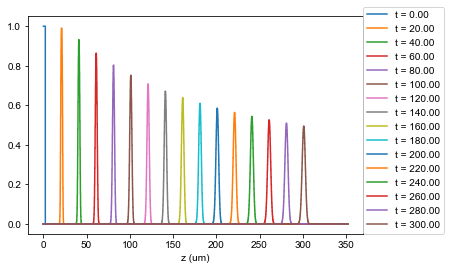

In [183]:
rs.plot_density('e', axis=2, ls='steps')

for i in range(15):
    rs.evolve(200, show_tqdm=False)
    rs.plot_density('e', axis=2, ls='steps')
plt.legend(loc=(1, 0))

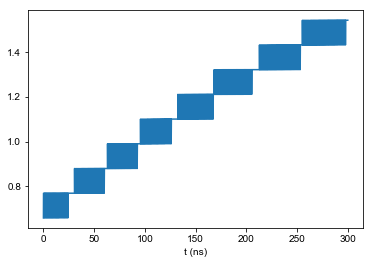

In [184]:
rs.plot_t('e_z_sigma')

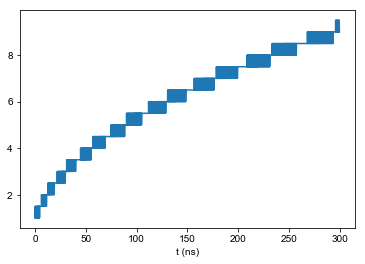

In [169]:
rs.plot_t('e_z_sigma')

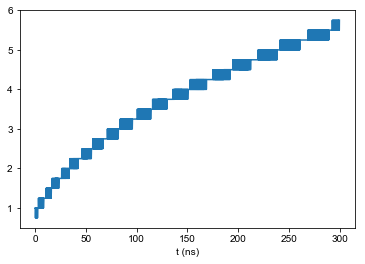

In [164]:
rs.plot_t('e_z_sigma')

100%|██████████| 250/250 [00:02<00:00, 92.05it/s] 


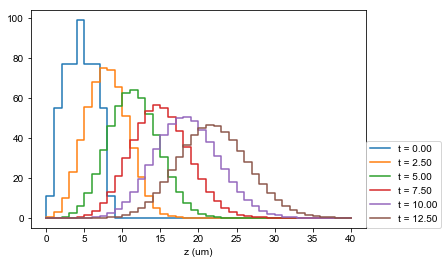

In [27]:
rs.plot_density('e', axis=2, ls='steps')

for i in range(5):
    rs.evolve(250, show_tqdm=True)
    rs.plot_density('e', axis=2, ls='steps')
plt.legend(loc=(1, 0))

In [22]:
rs.config

{'alpha': 0.0,
 'drift': True,
 'e_diff_const': 0.0,
 'max_n_errors': 5,
 'max_outflow_fraction': 0.2,
 'tau': 22,
 'v_d': 1.404}

In [767]:
rs.print_summary()

================ SUMMARY OF SIMULATION ================
ELECTRON FATE
Escaped: 78.6 %


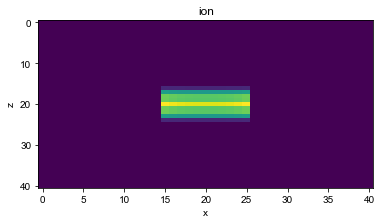

In [769]:
rs.plot_density_2d('ion')

In [739]:
d = rs.data()
t = d['t']
y = d['ex_decay']

In [740]:
d

,_maximum_relative_outflow,e_out,e_out_x+,e_out_x-,e_out_y+,e_out_y-,e_out_z+,e_out_z-,e_sum,ex_decay,ex_n,ex_production,t
0,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,143.000000,0.000000,0.129410,0.129410,0.00
1,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.870590,0.000059,0.248512,0.119161,0.01
2,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.751429,0.000113,0.359613,0.111214,0.02
3,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.640215,0.000163,0.464231,0.104782,0.03
4,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.535433,0.000211,0.563409,0.099388,0.04
5,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.436045,0.000256,0.657889,0.094736,0.05
6,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.341309,0.000299,0.748225,0.090635,0.06
7,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.250674,0.000340,0.834842,0.086958,0.07
8,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.163716,0.000379,0.918081,0.083619,0.08
9,0.27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,142.080098,0.000417,0.998220,0.080556,0.09


In [712]:
from scipy.optimize import curve_fit

In [713]:
sel = t > 15
def expfunc(x, a, tau):
    return a * np.exp(-x/tau)

In [714]:
popt, _ = curve_fit(expfunc, t[sel], y[sel])

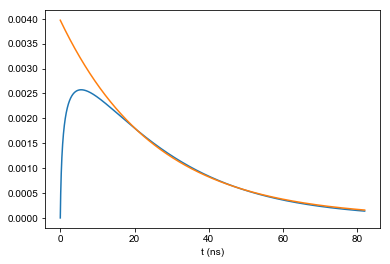

In [715]:
rs.plot_t('ex_decay')
plt.plot(t, expfunc(t, *popt))


In [716]:
popt

array([  3.96955554e-03,   2.54315989e+01])

In [12]:
rs = RecSim(np.linspace(-20, 20, 41), np.linspace(-20, 20, 41), np.linspace(-20, 20, 41), dt=1, 
           e_diff_const = 0.1, alpha=0.1, tau=22)

In [13]:
rs.set_density_sphere(5, [0, 0, 0], 'e')

In [14]:
rs.set_density_sphere(5, [0, 0, 0], 'ion')

In [15]:
rs.evolve(1000, show_tqdm=True)

100%|██████████| 1000/1000 [00:09<00:00, 102.33it/s]


In [558]:
d = rs.data()

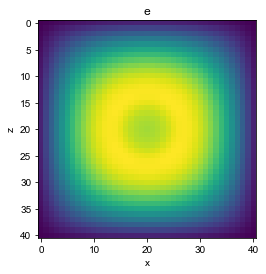

In [559]:
rs.plot_density('e')
plt.show()

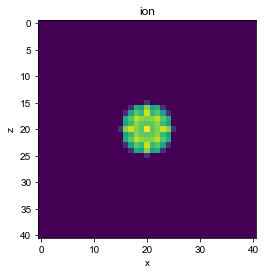

In [560]:
rs.plot_density('ion')
plt.show()

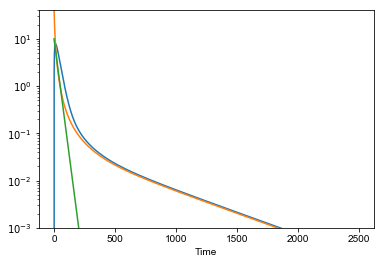

In [561]:
plt.plot(d['t'], d['ex_decay'], label = 'decay')
plt.plot(d['t'], d['ex_production'], label='production')
plt.plot(d['t'], 10 * np.exp(-d['t'] / 22), label='direct ex')
# plt.plot(d['t'], d['ex_n'])
plt.ylim(1e-3, 40)
plt.xlabel('Time')
plt.yscale('log')

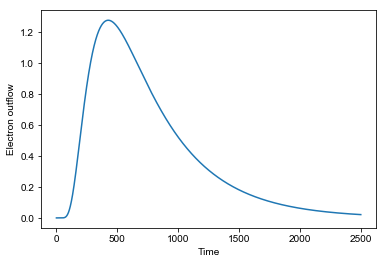

In [562]:
plt.plot(d['t'], d['e_out'], label = 'decay')
plt.xlabel('Time')
plt.ylabel('Electron outflow')

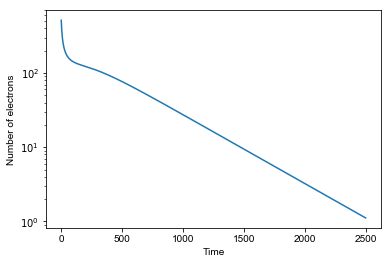

In [563]:
plt.plot(d['t'], d['e_sum'], label = 'Total n_electrons')
plt.xlabel('Time')
plt.ylabel('Number of electrons')
plt.yscale('log')